## Imports

In [1]:
import os 
import sys

import torch

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import clear_output

import importlib

import torch.nn as nn

import time

sys.path.append(os.path.abspath(os.path.join('..')))

## Image

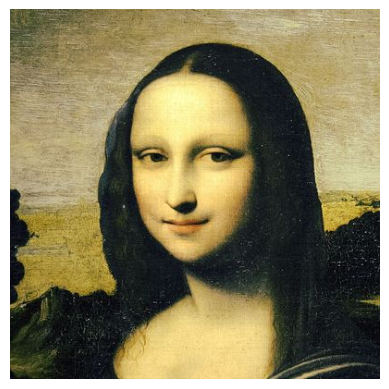

In [2]:
# image from link
url = "https://pyxis.nymag.com/v1/imgs/ccd/8a6/a1c2985ae120955603d45c82ebee96d8d3-29-Mona-Lisa.rsquare.w400.jpg"
# load image from this link
import urllib.request
from PIL import Image

image = Image.open(urllib.request.urlopen(url))

# tensor


# convert image to numpy array
image = np.array(image)
# crop and resize to 128x128
image = np.array(Image.fromarray(image).resize((400, 400)))

plt.imshow(image)
plt.axis('off')
plt.show()

## Retinal Compression

This might be best suited for in the dataloader as we only want this operation at the beginning of the retinal pathway. FOV of the phosphene simulator is typically set to 16. Look at config file and use variable.

In [3]:
import components.RetinalCompression as RetinalCompressionModule
importlib.reload(RetinalCompressionModule)

ret = RetinalCompressionModule.RetinalCompression()

In [4]:
compressed = ret.single(image=image,   fov=16, out_size=128, inv=0, type=0, show=0, masking=1, series=1, masktype=1)
percept = ret.single(image=compressed, fov=16, out_size=128, inv=1, type=0, show=0, masking=1, series=0, masktype=1)

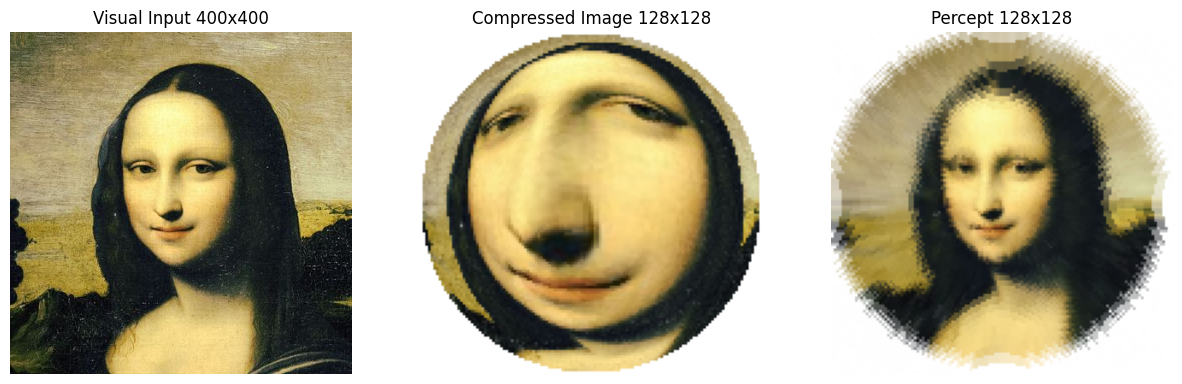

In [5]:
# Plot image, compressed image, and perceptual image
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].axis('off')
# Size in title
ax[0].set_title('Visual Input ' + str(image.shape[0]) + 'x' + str(image.shape[1]))
ax[1].imshow(compressed)
ax[1].axis('off')
ax[1].set_title('Compressed Image ' + str(compressed.shape[0]) + 'x' + str(compressed.shape[1]))
ax[2].imshow(percept)
ax[2].axis('off')
ax[2].set_title('Percept ' + str(percept.shape[0]) + 'x' + str(percept.shape[1]))
plt.show()

Computational complexity of Retinal Compression is $O(N^2)$, where NN is the size of the grid (e.g., for a $256×256$ image, $N=256$). This is only for the first run! We can use series=1 to reuse the mappings.

# Difference of Gaussian

Difference of Gaussian implements a center-surround receptive field.

In [6]:
from components import DoG
importlib.reload(DoG)

from components.DoG import DoGConv2D, DoGConv2DLayer

In [7]:
n_input = 3
n_output = 3
k_size = 3
stride = 1
padding = 1

img_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()

rez = 400
img_tensor = nn.functional.interpolate(img_tensor, size=(rez, rez), mode='bilinear', align_corners=False)

# Normal Conv2D
conv = nn.Conv2d(in_channels=n_input, out_channels=n_output, kernel_size=k_size, stride=stride, padding=padding)
# set weights to 1
# conv.weight.data.fill_(1/(k_size*k_size*3))
# conv.bias.data.fill_(0)
conv_out = conv(img_tensor)

# DoGConv2D
dog = DoGConv2DLayer(n_input, k=k_size, stride=stride, padding=padding)
dog_out = dog(img_tensor)
dog_out = dog_out/dog_out.max()*255

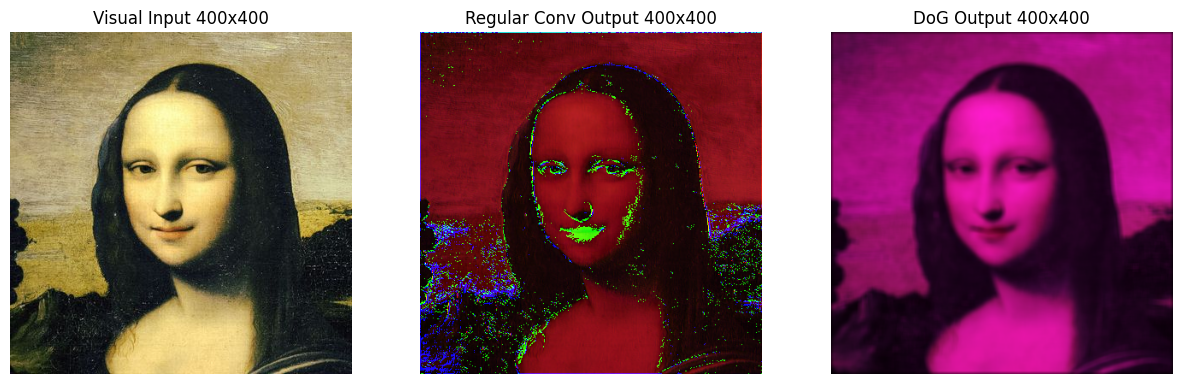

In [8]:
# Side by side resized_tensor, DoG output, and Conv output
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_tensor.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[0].axis('off')
ax[0].set_title('Visual Input ' + str(img_tensor.shape[2]) + 'x' + str(img_tensor.shape[3]))

ax[1].imshow(conv_out.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[1].axis('off')
ax[1].set_title('Regular Conv Output ' + str(conv_out.shape[2]) + 'x' + str(conv_out.shape[3]))
                
ax[2].imshow(dog_out.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[2].axis('off')
ax[2].set_title('DoG Output ' + str(dog_out.shape[2]) + 'x' + str(dog_out.shape[3]))

plt.show()


In [9]:
# number of parameters in each layer
print('DoGConv2D Parameters:', sum(p.numel() for p in dog.parameters()))
print('Conv2D Parameters:', sum(p.numel() for p in conv.parameters()))

# Ratio
print('\nRatio:', sum(p.numel() for p in dog.parameters()) / sum(p.numel() for p in conv.parameters()))

DoGConv2D Parameters: 79
Conv2D Parameters: 84

Ratio: 0.9404761904761905


Conv2D Time: 0.1938464641571045
DoGConv2D Time: 0.3480353355407715


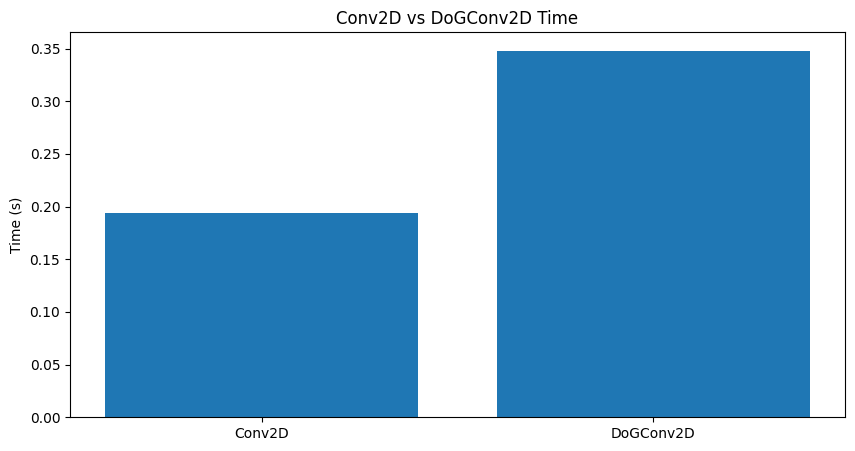

In [10]:
# Time
dummy_image = torch.randn(64, 3, 512, 512)

start = time.time()
conv_out = conv(dummy_image)
end = time.time()
conv2d_time = end-start
print('Conv2D Time:', end-start)

start = time.time()
dog_out = dog(dummy_image)
end = time.time()
dogconv2d_time = end-start
print('DoGConv2D Time:', dogconv2d_time)

# Plot times
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(['Conv2D', 'DoGConv2D'], [conv2d_time, dogconv2d_time])
ax.set_ylabel('Time (s)')
ax.set_title('Conv2D vs DoGConv2D Time')
plt.show()

# Local Receptive fields

In [11]:
from components import LocallyConnected2d
importlib.reload(LocallyConnected2d)

from components.LocallyConnected2d import LocallyConnected2d

In [12]:
n_input = 3
n_output = 3
output_size = 128
k_size = 3
stride = 1
padding = 1

res = 128
resized_img = np.array(Image.fromarray(image).resize((res, res))) 
tensor_img = torch.tensor(resized_img).permute(2, 0, 1).unsqueeze(0).float() # shape torch.Size([1, 3, 64, 64])
tensor_img.requires_grad = True

# Fully Connected Layer
fullyConnected = nn.Linear(in_features=3*res*res, out_features=3*res*res)
# set all weights to 
fullyConnected.weight.data.fill_(1/(res*res*3))
fully_connected_out = fullyConnected(tensor_img.reshape(1, -1))

# Locally Connected Layer
locallyConnected2dlayer = LocallyConnected2d(in_channels=n_input, 
                                             out_channels=n_output, 
                                             output_size=output_size, 
                                             kernel_size=k_size, 
                                             stride=stride, 
                                             padding=padding)
locallyConnected2dlayer.weight.data.fill_(1/(k_size*k_size*3))
locally_connected_out = locallyConnected2dlayer(tensor_img)

# Select a specific neuron e.g. the middle one
neuron_position = (int(res/2), int(res/2))
neuron_activation = locally_connected_out[0, 0, neuron_position[0], neuron_position[1]]

# Backpropagate to the input image
locallyConnected2dlayer.zero_grad()
neuron_activation.backward(retain_graph=True)

# Get the gradient of the input image
gradient = tensor_img.grad

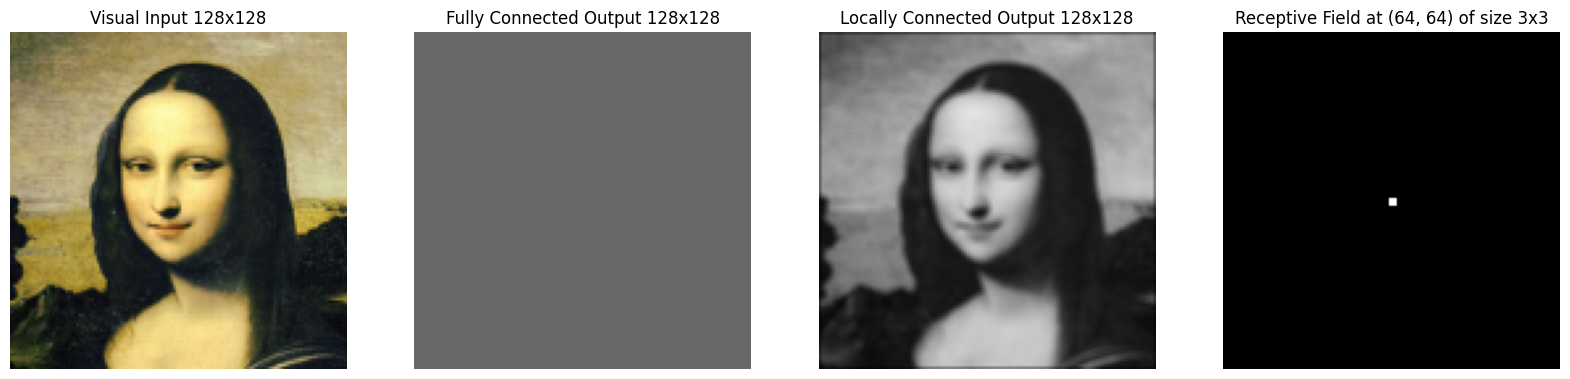

In [13]:
# Side by side input, Fully Connected output, Locally Connected output, and receptive field
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(resized_img)
ax[0].axis('off')
ax[0].set_title('Visual Input ' + str(resized_img.shape[0]) + 'x' + str(resized_img.shape[1]))

ax[1].imshow(fully_connected_out.detach().reshape(3, res, res).permute(1, 2, 0).numpy().astype(np.uint8))
ax[1].axis('off')
ax[1].set_title('Fully Connected Output ' + str(res) + 'x' + str(res))

ax[2].imshow(locally_connected_out.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[2].axis('off')
ax[2].set_title('Locally Connected Output ' + str(locally_connected_out.shape[2]) + 'x' + str(locally_connected_out.shape[3]))

ax[3].imshow(((gradient!=0)*255).squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[3].axis('off')
ax[3].set_title('Receptive Field at ' + str(neuron_position) + ' of size ' + str(k_size) + 'x' + str(k_size))
plt.show()

In [14]:
# number of parameters in each layer
print('LocallyConnected2d Parameters:', sum(p.numel() for p in locallyConnected2dlayer.parameters()))
print('FullyConnected Parameters:', sum(p.numel() for p in fullyConnected.parameters()))

# Ratio
print('\nRatio:', sum(p.numel() for p in locallyConnected2dlayer.parameters()) / sum(p.numel() for p in fullyConnected.parameters()))

LocallyConnected2d Parameters: 1327104
FullyConnected Parameters: 2415968256

Ratio: 0.0005493052306064736


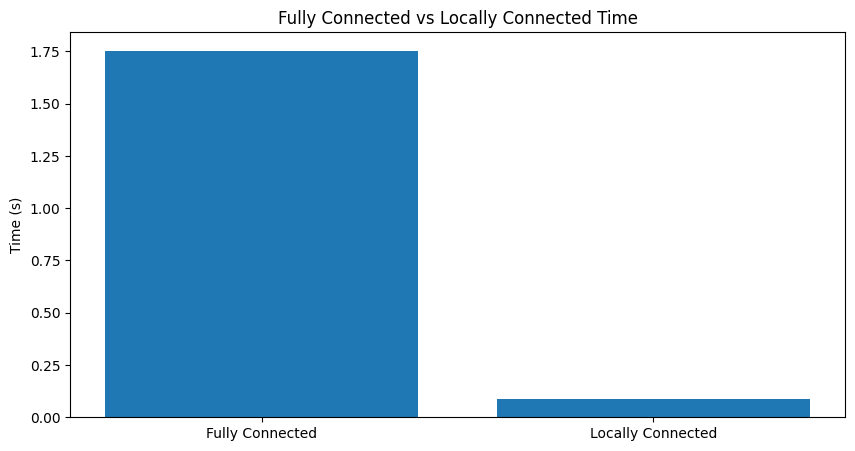

In [15]:
# Time tests
dummy_image = torch.randn(16, 3, 128, 128)

start = time.time()
fully_connected_out = fullyConnected(dummy_image.reshape(dummy_image.shape[0], -1))
end = time.time()
fully_connected_time = end-start

start = time.time()
locally_connected_out = locallyConnected2dlayer(dummy_image)
end = time.time()
locally_connected_time = end-start

# Plot times
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(['Fully Connected', 'Locally Connected'], [fully_connected_time, locally_connected_time])
ax.set_ylabel('Time (s)')
ax.set_title('Fully Connected vs Locally Connected Time')
plt.show()

# Divisive Normalization

In [16]:
from components import DivisiveNormalization
importlib.reload(DivisiveNormalization)

from components.DivisiveNormalization import DivisiveNormalizationCirincione, OpponentChannelInhibition

In [17]:
tensor_img = torch.tensor(np.array(Image.fromarray(image))).permute(2, 0, 1).unsqueeze(0).float()

In [18]:
divisize_norm = DivisiveNormalizationCirincione(channels=3, gaussian_kernel_size=3)
divisive_norm_out = divisize_norm(tensor_img)
divisive_norm_out = divisive_norm_out/divisive_norm_out.max()*255

opponent_channel_inhibition = OpponentChannelInhibition(n_channels=3)
opponent_channel_inhibition_out = opponent_channel_inhibition(tensor_img)
opponent_channel_inhibition_out = opponent_channel_inhibition_out/opponent_channel_inhibition_out.max()*255

# Normal normalization
norm = nn.LocalResponseNorm(size=3, alpha=1e-4, beta=0.75, k=1)
norm_out = norm(tensor_img)
# norm_out = norm_out/norm_out.max()*255

# Batch Normalization
batch_norm = nn.BatchNorm2d(3)
batch_norm_out = batch_norm(tensor_img)
# batch_norm_out = batch_norm_out/batch_norm_out.max()*255


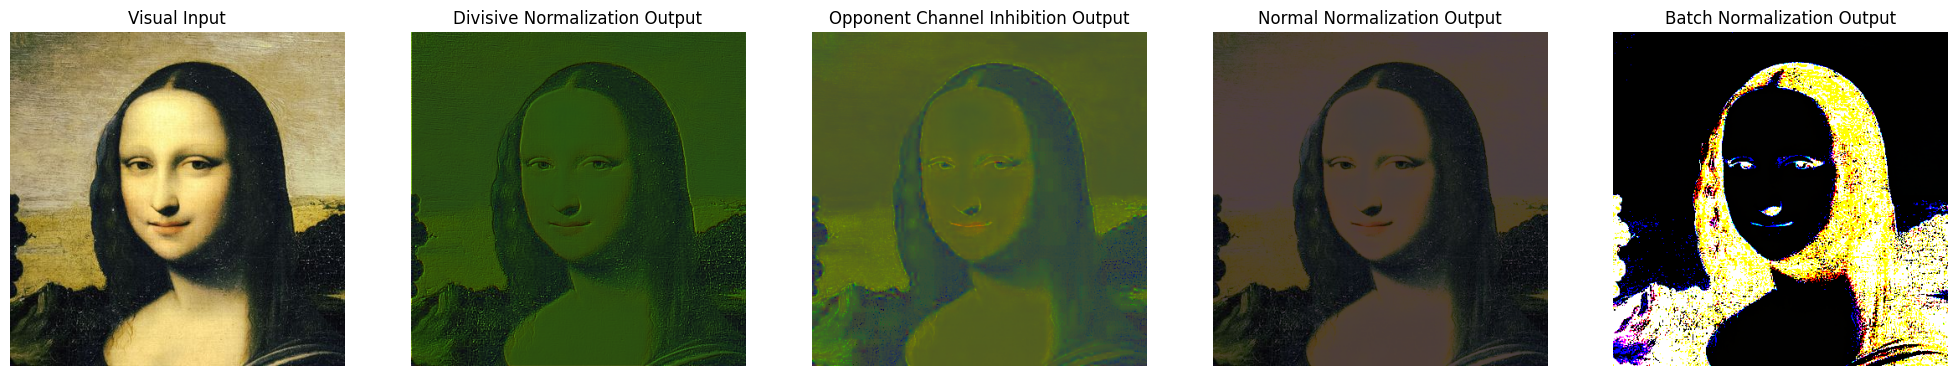

In [19]:
# Show the input image, Divisive Normalization output, and Opponent Channel Inhibition output
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
ax[0].imshow(tensor_img.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[0].axis('off')
ax[0].set_title('Visual Input')

ax[1].imshow(divisive_norm_out.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[1].axis('off')
ax[1].set_title('Divisive Normalization Output')

ax[2].imshow(opponent_channel_inhibition_out.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[2].axis('off')
ax[2].set_title('Opponent Channel Inhibition Output')

ax[3].imshow(norm_out.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[3].axis('off')
ax[3].set_title('Normal Normalization Output')

ax[4].imshow(batch_norm_out.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[4].axis('off')
ax[4].set_title('Batch Normalization Output')

plt.show()

In [20]:
# number of parameters in each layer
print('DivisiveNormalizationCirincione Parameters:', sum(p.numel() for p in divisize_norm.parameters()))
print('OpponentChannelInhibition Parameters:', sum(p.numel() for p in opponent_channel_inhibition.parameters()))
print('LocalResponseNorm Parameters:', sum(p.numel() for p in norm.parameters()))
print('BatchNorm2d Parameters:', sum(p.numel() for p in batch_norm.parameters()))

DivisiveNormalizationCirincione Parameters: 55
OpponentChannelInhibition Parameters: 12
LocalResponseNorm Parameters: 0
BatchNorm2d Parameters: 6


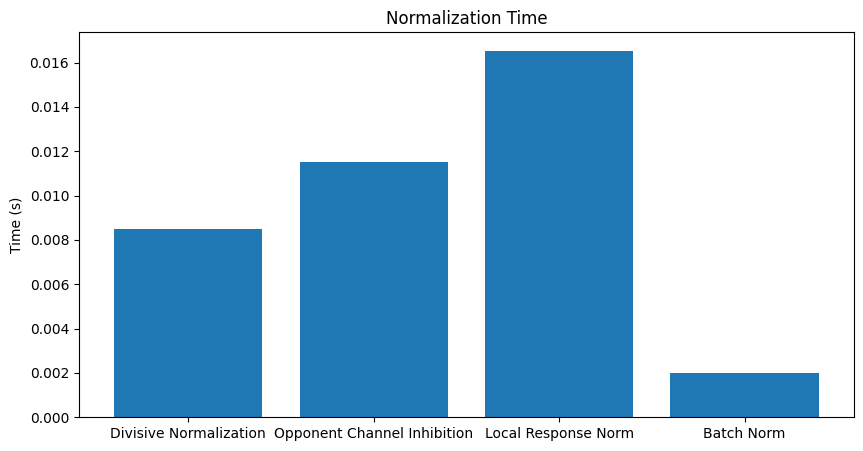

In [21]:
# Time tests
dummy_image = torch.randn(16, 3, 128, 128)

start = time.time()
divisive_norm_out = divisize_norm(dummy_image)
end = time.time()
divisive_norm_time = end-start

start = time.time()
opponent_channel_inhibition_out = opponent_channel_inhibition(dummy_image)
end = time.time()
opponent_channel_inhibition_time = end-start

start = time.time()
norm_out = norm(dummy_image)
end = time.time()
norm_time = end-start

start = time.time()
batch_norm_out = batch_norm(dummy_image)
end = time.time()
batch_norm_time = end-start

# Plot times
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(['Divisive Normalization', 'Opponent Channel Inhibition', 'Local Response Norm', 'Batch Norm'], 
       [divisive_norm_time, opponent_channel_inhibition_time, norm_time, batch_norm_time])
ax.set_ylabel('Time (s)')
ax.set_title('Normalization Time')
plt.show()

# Polar Transform
For cortical magnification

In [22]:
from components import PolarTransform
importlib.reload(PolarTransform)

from components.PolarTransform import PolarTransform

In [23]:
res = 128
resized_img = np.array(Image.fromarray(image).resize((res, res))) 
tensor_img = torch.tensor(resized_img).permute(2, 0, 1).unsqueeze(0).float()

In [24]:
img_size = tensor_img.shape[2]
out_size = 128
input_h, input_w = img_size, img_size
output_h, output_w = out_size, out_size
interpolation = 'linear'

foveal_radius = 48  # Increasing the foveal radius
foveal_dists = np.arange(foveal_radius)
periphery_dists = [48, 50, 54, 60, 66, 76, 88, 100, 112, 124]
radius_bins = list(foveal_dists) + list(periphery_dists)
angle_bins = list(np.linspace(0, 2*np.pi, img_size+1-2))

polar_transform = PolarTransform(
                                input_h=input_h,
                                input_w=input_w,
                                output_h=output_h,
                                output_w=output_w,
                                radius_bins=radius_bins,
                                angle_bins=angle_bins,
                                interpolation=interpolation)

In [25]:
polar_transform_out = polar_transform(tensor_img)

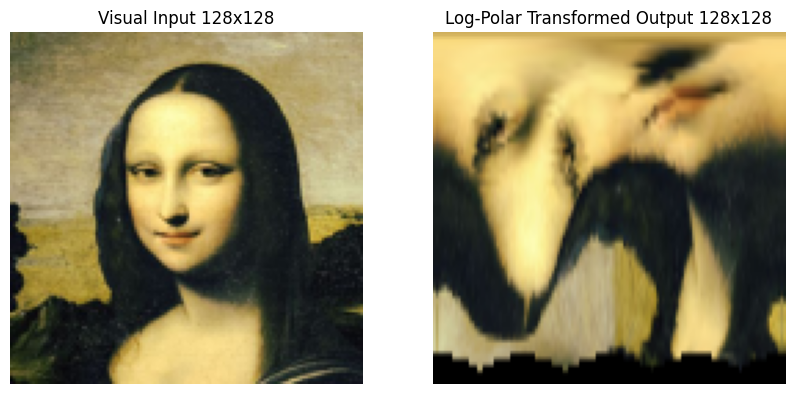

In [26]:
# Visualize the input image and the polar transformed image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(resized_img)
ax[0].axis('off')
ax[0].set_title('Visual Input ' + str(resized_img.shape[0]) + 'x' + str(resized_img.shape[1]))

ax[1].imshow(polar_transform_out.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[1].axis('off')
ax[1].set_title('Log-Polar Transformed Output ' + str(polar_transform_out.shape[2]) + 'x' + str(polar_transform_out.shape[3]))

plt.show()


In [27]:
# Time tests
dummy_image = torch.randn(16, 3, 128, 128)

start = time.time()
polar_transform_out = polar_transform(dummy_image)
end = time.time()
polar_transform_time = end-start

print('Polar Transform Time:', polar_transform_time)

Polar Transform Time: 0.12284564971923828


# Retinal Neural Encoder
Inpired by the retinal pathway and LGN

## Retinal Residual Block

In [28]:
from model import ResidualBlock, convlayer, E2E_Encoder_nophosphenes

In [29]:
class RetinalResidualBlock(nn.Module):
    def __init__(self, n_channels, stride=1, resample_out=None):
        super(RetinalResidualBlock, self).__init__()
        # Dog layer
        self.dogconv1 = DoGConv2D(n_channels, n_channels, k=3, stride=stride, padding=1)
        self.divnorm1 = OpponentChannelInhibition(n_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.dogconv2 = DoGConv2D(n_channels, n_channels, k=3, stride=stride, padding=1)
        self.oppinhibition1 = OpponentChannelInhibition(n_channels)
        self.resample_out = resample_out

    def forward(self, x):
        # residual = x
        out = self.dogconv1(x)
        out = self.divnorm1(out)
        out = self.relu(out)
        out = self.dogconv2(out)
        out = self.oppinhibition1(out)
        # out += residual
        out = self.relu(out)
        if self.resample_out:
            out = self.resample_out(out)
        return out

In [30]:
retinal_residual_block = RetinalResidualBlock(n_channels=3)

normal_residual_block = ResidualBlock(n_channels=3)

out_retinal = retinal_residual_block(tensor_img)

out_normal = normal_residual_block(tensor_img)

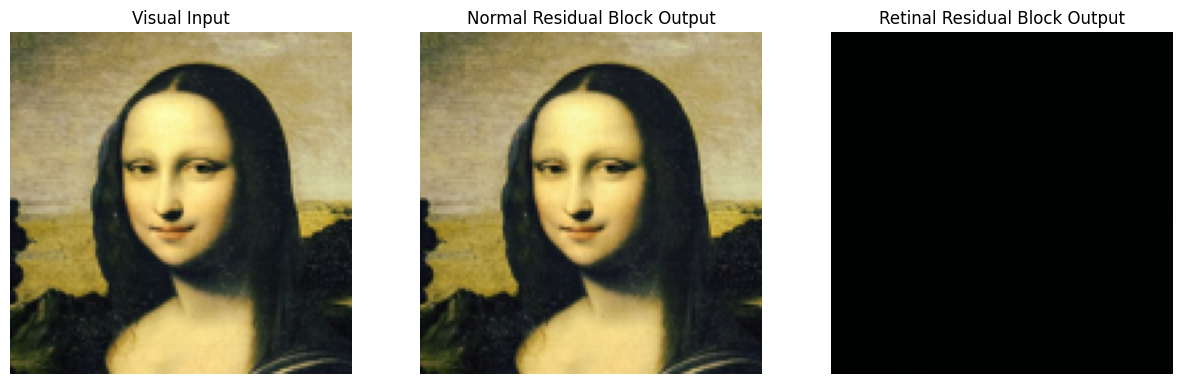

In [31]:
# show input, normal and retinal residual block output
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(tensor_img.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[0].axis('off')
ax[0].set_title('Visual Input')

ax[1].imshow(out_normal.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[1].axis('off')
ax[1].set_title('Normal Residual Block Output')

ax[2].imshow(out_retinal.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[2].axis('off')
ax[2].set_title('Retinal Residual Block Output')

plt.show()

RetinalResidualBlock Parameters: 182
NormalResidualBlock Parameters: 180


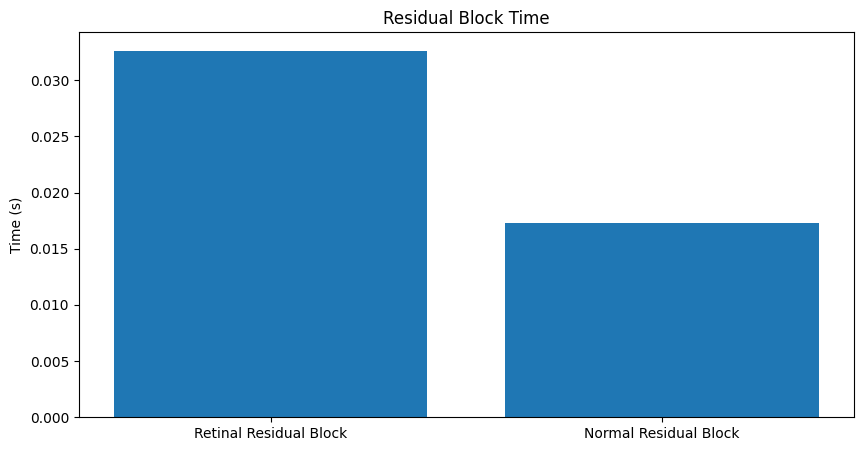

In [32]:
# Compare the number of parameters and time
print('RetinalResidualBlock Parameters:', sum(p.numel() for p in retinal_residual_block.parameters()))
print('NormalResidualBlock Parameters:', sum(p.numel() for p in normal_residual_block.parameters()))

# Time tests
dummy_image = torch.randn(16, 3, 128, 128)

start = time.time()
retinal_residual_block(dummy_image)
end = time.time()
retinal_residual_block_time = end-start

start = time.time()
normal_residual_block(dummy_image)
end = time.time()
normal_residual_block_time = end-start

# Plot times
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(['Retinal Residual Block', 'Normal Residual Block'], [retinal_residual_block_time, normal_residual_block_time])
ax.set_ylabel('Time (s)')
ax.set_title('Residual Block Time')
plt.show()


## Retinal convolutional layer

In [33]:
def retinalconvlayer(n_input, n_output, k_size=3, stride=1, padding=1, resample_out=None):
    layer = [
        DoGConv2D(n_input, n_output, k=k_size, stride=stride, padding=padding),
        nn.BatchNorm2d(n_output),
        nn.LeakyReLU(inplace=True),
        resample_out]
    if resample_out is None:
        layer.pop()
    return layer

In [34]:
# test retinal convlayer   
retinalconv = nn.Sequential(*retinalconvlayer(n_input=3, n_output=3))

normalconv = nn.Sequential(*convlayer(n_input=3, n_output=3))

retinal_out = retinalconv(tensor_img)

normal_out = normalconv(tensor_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


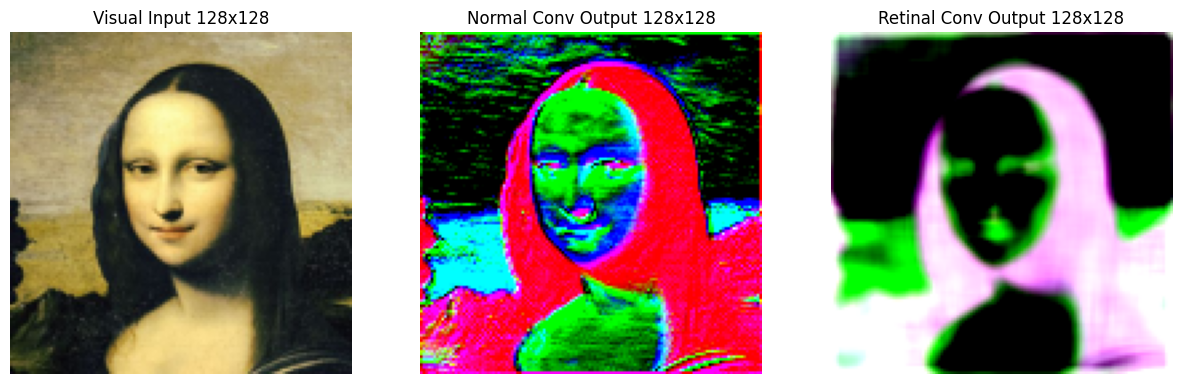

In [35]:
# show input, normal and retinal convlayer output
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(tensor_img.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[0].axis('off')
ax[0].set_title('Visual Input ' + str(tensor_img.shape[2]) + 'x' + str(tensor_img.shape[3]))

ax[1].imshow(normal_out.squeeze().permute(1, 2, 0).detach().numpy())
ax[1].axis('off')
ax[1].set_title('Normal Conv Output ' + str(normal_out.shape[2]) + 'x' + str(normal_out.shape[3]))

ax[2].imshow(retinal_out.squeeze().permute(1, 2, 0).detach().numpy())
ax[2].axis('off')
ax[2].set_title('Retinal Conv Output ' + str(retinal_out.shape[2]) + 'x' + str(retinal_out.shape[3]))

plt.show()

RetinalConvLayer Parameters: 85
NormalConvLayer Parameters: 87


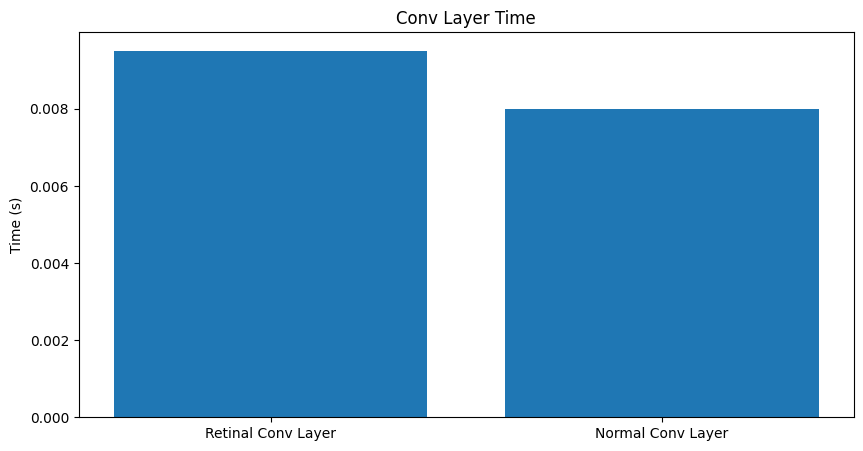

In [36]:
# Compare the number of parameters and time
print('RetinalConvLayer Parameters:', sum(p.numel() for p in retinalconv.parameters()))
print('NormalConvLayer Parameters:', sum(p.numel() for p in normalconv.parameters()))

# Time tests
dummy_image = torch.randn(16, 3, 128, 128)

start = time.time()
retinalconv(dummy_image)
end = time.time()
retinalconv_time = end-start

start = time.time()
normalconv(dummy_image)
end = time.time()
normalconv_time = end-start

# Plot times
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(['Retinal Conv Layer', 'Normal Conv Layer'], [retinalconv_time, normalconv_time])
ax.set_ylabel('Time (s)')
ax.set_title('Conv Layer Time')
plt.show()


## Retinal encoder without phosphenes, latent space output

In [37]:
class retinal_encoder_nophosphenes(nn.Module):
    """
    Simple non-generic encoder class that receives 128x128 input and outputs 256x256 feature map.
    """
    def __init__(self, in_channels=3, out_channels=1, out_scaling=1e-4, out_activation='relu'):
        super(retinal_encoder_nophosphenes, self).__init__()
        self.output_scaling = out_scaling
        self.out_activation = {'tanh': nn.Tanh(),
                               'sigmoid': nn.Sigmoid(),
                               'relu': nn.ReLU(),
                               'softmax': nn.Softmax(dim=1)}[out_activation]

        # Model
        self.model = nn.Sequential(
            *retinalconvlayer(in_channels, 8, 3, 1, 1),
            *retinalconvlayer(8, 16, 3, 1, 1, resample_out=nn.MaxPool2d(2)),  # Output is 64x64
            *retinalconvlayer(16, 32, 3, 1, 1, resample_out=nn.MaxPool2d(2)),  # Output is 32x32
            # RetinalResidualBlock(32),
            # RetinalResidualBlock(32),
            # RetinalResidualBlock(32),
            # RetinalResidualBlock(32),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # Upsample to 64x64
            *retinalconvlayer(32, 16, 3, 1, 1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # Upsample to 128x128
            *retinalconvlayer(16, out_channels, 3, 1, 1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # Upsample to 256x256
            self.out_activation
        )

    def forward(self, x):
        x = self.model(x)
        # x = x * self.output_scaling  # Scaling to improve numerical stability
        return x

In [38]:
retinal_encoder = retinal_encoder_nophosphenes()

retinal_encoder_out = retinal_encoder(tensor_img)
print(retinal_encoder_out.shape)

normal_encoder = E2E_Encoder_nophosphenes()

normal_encoder_out = normal_encoder(tensor_img)
print(normal_encoder_out.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


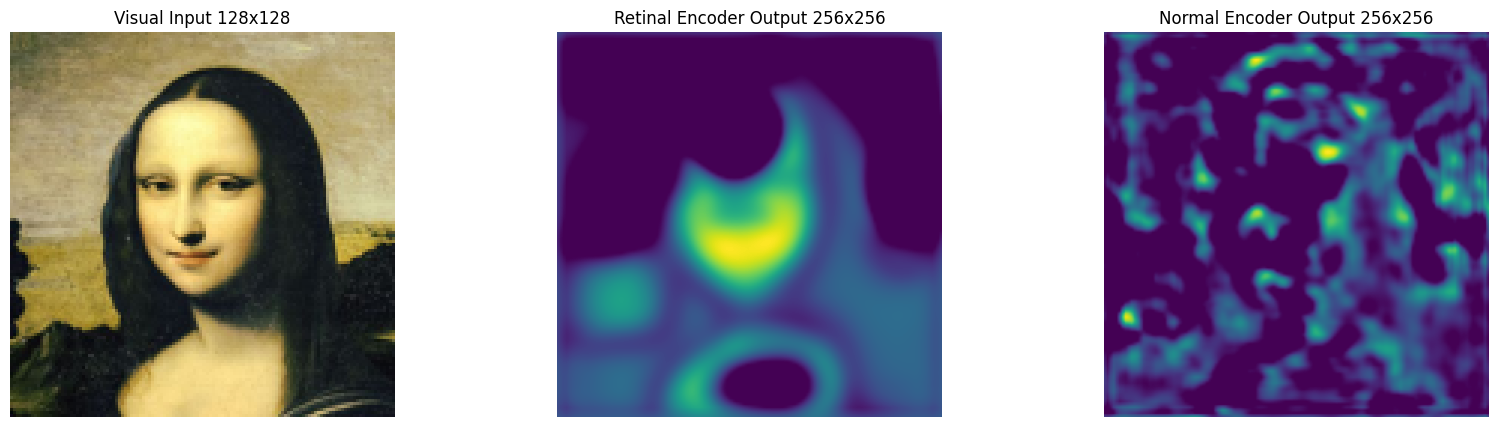

In [39]:
# plot input and output of retinal and normal encoder
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].imshow(tensor_img.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[0].axis('off')
ax[0].set_title('Visual Input ' + str(tensor_img.shape[2]) + 'x' + str(tensor_img.shape[3]))

ax[1].imshow(retinal_encoder_out.squeeze().detach().numpy())
ax[1].axis('off')
ax[1].set_title('Retinal Encoder Output ' + str(retinal_encoder_out.shape[2]) + 'x' + str(retinal_encoder_out.shape[3]))

ax[2].imshow(normal_encoder_out.squeeze().detach().numpy())
ax[2].axis('off')
ax[2].set_title('Normal Encoder Output ' + str(normal_encoder_out.shape[2]) + 'x' + str(normal_encoder_out.shape[3]))

plt.show()

Retinal Encoder Parameters: 4040
Normal Encoder Parameters: 85370

Ratio: 0.047323415719807894


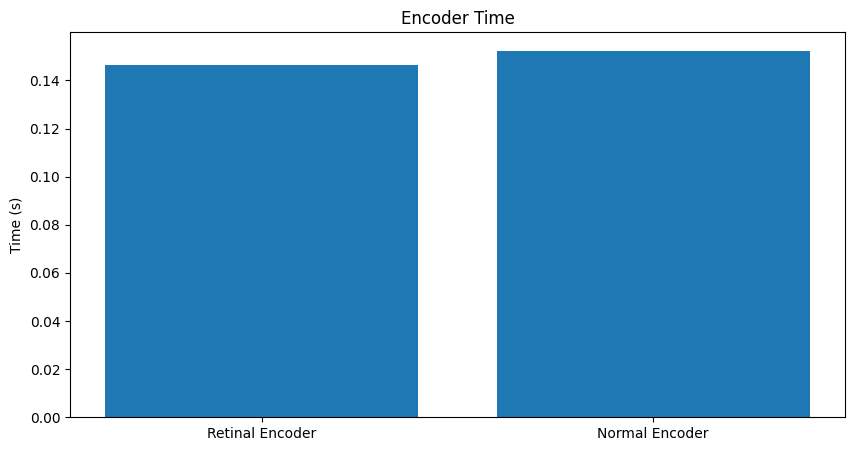

In [40]:
# Amount of parameters and time
print('Retinal Encoder Parameters:', sum(p.numel() for p in retinal_encoder.parameters()))
print('Normal Encoder Parameters:', sum(p.numel() for p in normal_encoder.parameters()))
# Ratio
print('\nRatio:', sum(p.numel() for p in retinal_encoder.parameters()) / sum(p.numel() for p in normal_encoder.parameters()))

# Time tests
dummy_image = torch.randn(16, 3, 128, 128)

start = time.time()
retinal_encoder(dummy_image)
end = time.time()
retinal_encoder_time = end-start

start = time.time()
normal_encoder(dummy_image)
end = time.time()
normal_encoder_time = end-start

# Plot times
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(['Retinal Encoder', 'Normal Encoder'], [retinal_encoder_time, normal_encoder_time])
ax.set_ylabel('Time (s)')
ax.set_title('Encoder Time')
plt.show()


# With Phosphene Simulator

In [41]:
import yaml
import dynaphos
import pickle

import dynaphos
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from utils import resize

def load_config(yaml_file):
    with open(yaml_file) as file:
        raw_content = yaml.load(file,Loader=yaml.FullLoader) # nested dictionary
    return {k:v for params in raw_content.values() for k,v in params.items()} # unpacked

cfg = load_config('../_config/exp-local/faces_boundary_supervised_phosphenes_no_decoder.yaml')
cfg['retinal_compression'] = True
cfg['data_directory'] = '../../data/face/LaPa'
cfg['fov'] = 5
cfg['base_config'] = '../_config/exp-local/simulator_config.yaml'
cfg['phosphene_map'] = '../_config/phosphene_maps/DefaultCoordinateMap_1000_phosphenes.pickle'
cfg['batch_size'] = 1
cfg['resolution'] = [128, 128]

In [42]:
def get_simulator(cfg):
    # initialise simulator
    params = dynaphos.utils.load_params(cfg['base_config'])
    params['run'].update(cfg)
    params['thresholding'].update(cfg)

    with open(cfg['phosphene_map'], 'rb') as handle:
        coordinates_visual_field = pickle.load(handle, )
    simulator = PhospheneSimulator(params, coordinates_visual_field)
    cfg['SPVsize'] = simulator.phosphene_maps.shape[-2:]
    return simulator

simulator = get_simulator(cfg)

torch.Size([1, 3, 128, 128])


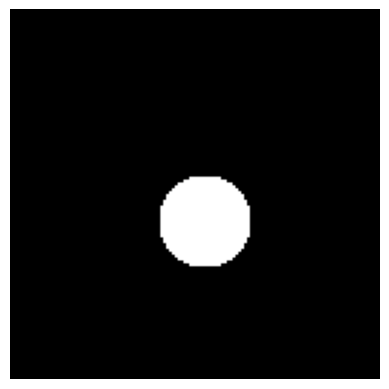

In [43]:
# Random image generator
def random_image_generator(batch_size=1, channels=3, height=128, width=128):
    # black background
    image = torch.zeros(batch_size, channels, height, width)
    
    # sample 2 values from the normal distribution
    mean = 0
    std = 0.9
    x_off, y_off = torch.normal(mean=mean, std=std, size=(2,))
    # use values to determine center of circle
    x_center = int(width/2 + x_off*width/4)
    y_center = int(height/2 + y_off*height/4)

    random_size = np.random.randint(10, 30)
    # draw circle
    for i in range(height):
        for j in range(width):
            if (i - x_center)**2 + (j - y_center)**2 < random_size**2:
                image[0, :, i, j] = 1

    return image

# Random image
random_image = random_image_generator()
print(random_image.shape)
plt.imshow(random_image[0].permute(1, 2, 0).detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [60]:
class Retinal_Encoder(nn.Module):
    """
    Simple non-generic encoder class that receives 128x128 input and outputs 32x32 feature map as stimulation protocol
    """
    def __init__(self, in_channels=1, out_channels=1, n_electrodes=1000, out_scaling=1e-4, out_activation='relu'):
        super(Retinal_Encoder, self).__init__()
        self.output_scaling = out_scaling
        self.out_activation = {'tanh': nn.Tanh(), ## NOTE: simulator expects only positive stimulation values 
                               'sigmoid': nn.Sigmoid(),
                               'relu': nn.ReLU(),
                               'softmax':nn.Softmax(dim=1)}[out_activation]

        # Model
        self.model = nn.Sequential(
                                        *retinalconvlayer(in_channels,1,3,1,1, resample_out=nn.MaxPool2d(4)),
                                        nn.Flatten(),
                                        nn.Linear(1024, n_electrodes),
                                   self.out_activation)

    def forward(self, x):
        self.out = self.model(x)
        stimulation = self.out*self.output_scaling #scaling improves numerical stability
        return stimulation
    
retinal_encoder = Retinal_Encoder().to(cfg['device'])
torch.use_deterministic_algorithms(False)

# print(retinal_encoder)

# amount of params
print('Retinal Encoder Parameters:', sum(p.numel() for p in retinal_encoder.parameters()))

# test forward pass
random_image = random_image_generator(batch_size=1, channels=1, height=128, width=128).to(cfg['device'])

output = retinal_encoder(random_image)
print('out size:', output.shape)
output.min(), output.max()

Retinal Encoder Parameters: 1025055
out size: torch.Size([1, 1000])


(tensor(0., device='cuda:0', grad_fn=<MinBackward1>),
 tensor(3.6172e-05, device='cuda:0', grad_fn=<MaxBackward1>))

### Small round of training

Epoch 250 Loss: 0.04298827797174454


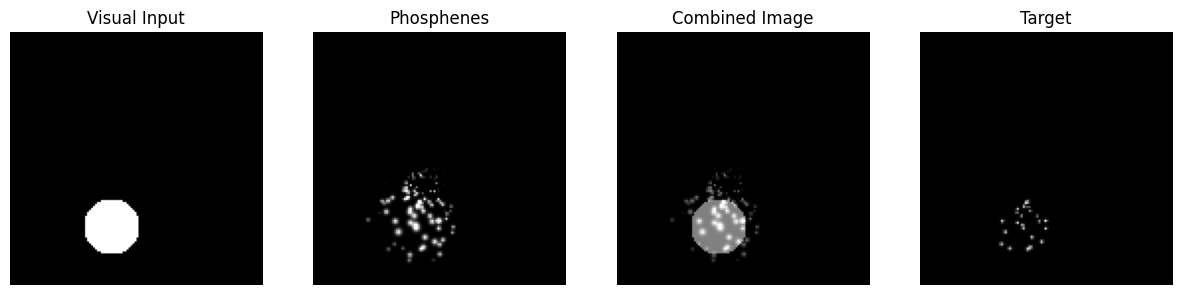

In [61]:
cfg['batch_size'] = 1

# Initialize the retinal encoder
cfg['output_scaling'] = 1e-4
retinal_encoder = Retinal_Encoder(out_activation='relu', out_scaling=cfg['output_scaling'])
retinal_encoder.to(cfg['device'])

# Define loss function
loss_fn = nn.L1Loss()

# Define optimizer
optimizer = torch.optim.Adam(retinal_encoder.parameters(), lr=0.0005)

# Set deterministic algorithms off
torch.use_deterministic_algorithms(False)

for i in range(300):
    # Generate random image and make non differentiable
    random_image = random_image_generator(batch_size=cfg['batch_size'], channels=1, height=128, width=128).to(cfg['device']).detach()

    # Forward pass
    simulator.reset()
    stimulation = retinal_encoder(random_image)
    phosphenes = simulator(stimulation).unsqueeze(1)
    phosphene_centers = simulator.sample_centers(phosphenes)
    
    # Define target
    resized = resize(random_image.float(), cfg['SPVsize'])
    target = simulator.sample_centers(resized.mean(1, keepdim=True))

    # Calculate loss
    loss = loss_fn(phosphene_centers, target)

    # Zero gradients, backward pass, and update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 50 == 0:
        clear_output(wait=True)

        print(f'Epoch {i} Loss: {loss.item()}')
        # show input image and phosphenes, and combined/overlayed image, target

        fig, ax = plt.subplots(1, 4, figsize=(15, 5))
        ax[0].imshow(random_image[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
        ax[0].axis('off')
        ax[0].set_title('Visual Input')

        # phosphene image
        ax[1].imshow(phosphenes[0].squeeze().detach().cpu().numpy(), cmap='gray')
        ax[1].axis('off')
        ax[1].set_title('Phosphenes')

        # combined image
        ax[2].imshow(random_image[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
        ax[2].imshow(phosphenes[0].squeeze().detach().cpu().numpy(), cmap='gray', alpha=0.5)
        ax[2].axis('off')
        ax[2].set_title('Combined Image')
    
        # target
        out = simulator(target*retinal_encoder.output_scaling)
        ax[3].imshow(out[0].squeeze().detach().cpu().numpy(), cmap='gray')
        ax[3].axis('off')
        ax[3].set_title('Target')

        plt.show()

In [62]:
stimulation.min(), stimulation.max()

(tensor(0., device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.0015, device='cuda:0', grad_fn=<MaxBackward1>))

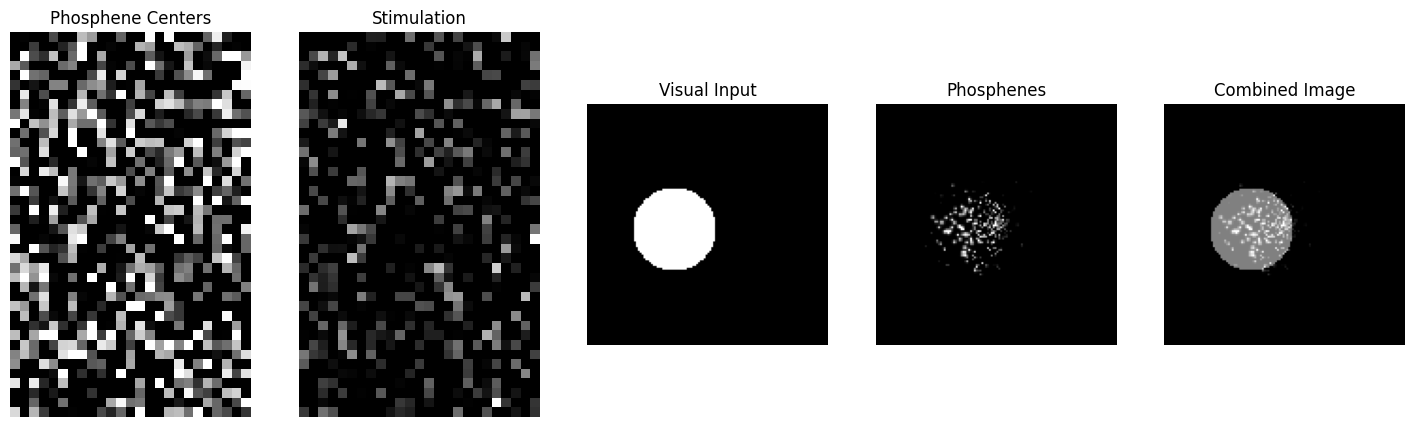

In [65]:
# difference between stimulation and phosphene_centers
random_image = random_image_generator(batch_size=1, channels=1, height=128, width=128).to(cfg['device']).detach()
stimulation = retinal_encoder(random_image)
phosphenes = simulator(stimulation).unsqueeze(1)
phosphene_centers = simulator.sample_centers(phosphenes)

phoshpene_centers_img = phosphene_centers.reshape(40, 25).detach().cpu().numpy()
stimulation_img = stimulation.reshape(40, 25).detach().cpu().numpy()

# plot side by side an difference between stimulation and phosphene_centers and random_image
fig, ax = plt.subplots(1, 5, figsize=(18, 5))
ax[0].imshow(phoshpene_centers_img, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Phosphene Centers')

ax[1].imshow(stimulation_img, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Stimulation')

ax[2].imshow(random_image[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
ax[2].axis('off')
ax[2].set_title('Visual Input')

# phosphenes
ax[3].imshow(phosphenes[0].squeeze().detach().cpu().numpy(), cmap='gray')
ax[3].axis('off')
ax[3].set_title('Phosphenes')

# combined image
ax[4].imshow(random_image[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
ax[4].imshow(phosphenes[0].squeeze().detach().cpu().numpy(), cmap='gray', alpha=0.5)
ax[4].axis('off')
ax[4].set_title('Combined Image')

plt.show()


torch.Size([1, 1, 128, 128])


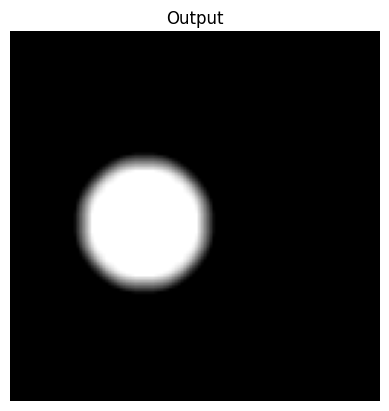

In [66]:
# image after first layer
first_layer_out = retinal_encoder.model[:3](random_image.to(cfg['device']))
print(first_layer_out.shape)

# plot
if first_layer_out.shape[1] > 1:
    fig, ax = plt.subplots(1, first_layer_out.shape[1], figsize=(20, 5))
    for i in range(first_layer_out.shape[1]):
        ax[i].imshow(first_layer_out[0, i].detach().cpu().numpy(), cmap='gray')
        ax[i].axis('off')
        ax[i].set_title('Output ' + str(i))
else:
    plt.imshow(first_layer_out[0, 0].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title('Output')